In [2]:
import Pkg; 
Pkg.add("BenchmarkTools")
Pkg.add("Plots")
Pkg.add("OrderedCollections")
Pkg.add("Latexify")

include("./modules.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


Main.CouplingConstants

Header and basic constants. Size of the lattice.

In [3]:
using LinearAlgebra
using Printf
using Plots


module MakeGraph:

Define the bonds in the model graph. Graph is a collection {Vector} of subgraphs with the same J. Each subgraph is a collection {Vector} of bonds {Tupples}. 

ladder(m)    ladded with m rungs (periodic b.c.)
loopNN(m)    m-site loop
loopNNN(m)    m-site loop with nnn interaction
square2D(m,n)  m x n square lattice (periodic b.c.)


In [35]:
loopNN(6)

1-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)]

Convesion between binary code and state index

In [36]:
const N=6   # number of sites 
const Bsize=2^N   # total basis size
const base_2=(2 .^(N-1:-1:0))  # conversion factors binary2decimal

bits2int(bits) = dot(bits,base_2)+1

function int2bits(n::Int)
    y=string(n-1, base = 2)
    parse.(Bool,collect(lpad(y,N,"0")))
end

int2bits (generic function with 1 method)

Functions to generate local spin operators in the current basis (iSy is anti-Hermitean -- to keep the operators as intereger matrices) :

bond: Defines the bond Hamiltonian. Here we use isotropic exchange $S_i\cdot S_j$.

alt_bond: This is a different (faster) way to generate $S_i\cdot S_j$ directly (does not allow x-y anisotropy.

In [37]:
Sz(site::Int)=collect(Diagonal(2*BitArray(int2bits(state)[site] for state = 1:Bsize).-1))

function Sx(site::Int)
    y=zeros(Int64,Bsize,Bsize)
    for k in 1:Bsize
        x=int2bits(k)
        x[site]=~x[site]
        l=bits2int(x)
        y[l,k]=1
    end
    return y
end

function iSy(site::Int)
    y=zeros(Int64,Bsize,Bsize)
    for k in 1:Bsize
        x=int2bits(k)
        x[site]=~x[site]
        l=bits2int(x)
        y[l,k]= (x[site] ? 1 : -1)
    end
    return y
end

bond(n::Tuple{Int64, Int64})=Sz(n[1])*Sz(n[2])+Sx(n[1])*Sx(n[2])-Sy(n[1])*Sy(n[2])

function alt_bond(n::Tuple{Int64, Int64})
        y=zeros(Int64,Bsize,Bsize)
    for k in 1:Bsize
        x=int2bits(k)
        if (x[n[1]] ⊻ x[n[2]])
                y[k,k]=-1
                x[n[1]]=~x[n[1]]
                x[n[2]]=~x[n[2]]
                l=bits2int(x)
                y[l,k]=2
            else
                y[k,k]=1
            end
    end
    return y
end

alt_bond (generic function with 1 method)

A function to generate the Hamiltonian on a given graph. Here we use two graphs loops and rungs.

In [32]:
function alt_Hamilt(b::Vector{Tuple{Int64, Int64}})   # generates Hamiltonian H_i for a subgraph
    x=zeros(Bsize,Bsize)
    for bond in b
        x+= alt_bond(bond)
    end
    return x
end

function Hamilt(graph::Vector{Vector{Tuple{Int64, Int64}}}, J::Number...)   # H=J_1 H_1+J_2 H_2 + ...
    x=zeros(Bsize,Bsize)   
    terms = min(length(graph),length(collect(J)))       # unspecified Js are taken to be zero
    for i in 1:terms
        x+= J[i]*alt_Hamilt(graph[i])
    end
    return x
end

Hamilt (generic function with 1 method)

module Operators:

Bweights!(eig::Vector, T::Real): turns a list of eigenenergies to list of Boltzmann weights. 
    
Bweights(eig::Vector, T::Real): generates Bolzmann weights

Z(eig::Vector, T::Real): partition function $Z$

FeeEnergy(eig::Vector, T::Real): $F=-T*ln Z$ 

Ene(eig::Vector, T::Real)=$\frac{1}{Z}\sum E_i \exp(-\frac{E_i}{T})$

Ene2(eig::Vector, T::Real)=$\frac{1}{Z}\sum E^2_i \exp(-\frac{E_i}{T})$

SpecificHeat(eig::Vector, T::Real)=$\frac{\langle E^2\rangle -\langle E\rangle^2}{T^2}$

Entropy(eig::Vector, T::Real)=$\frac{\langle E\rangle -F}{T}$

rho(H::Matrix, T::Real):  $\rho=\frac{\exp(-\beta H)}{Z}$

rhotol(H::Matrix, T::Real; tol::Real = 1e-6): $\rho=\frac{\exp(-\beta H)}{Z}$ (restricted summation)

meanv(H::Matrix, T::Real, O::Matrix...) = $\operatorname{Tr}\rho(H;T) O$

ILor(w::Real,x::Real,G::Real)=$\frac{G}{2\pi}(\frac{1}{(w-x)^2+G^2}-\frac{1}{(w+x)^2+G^2})$

RLor(w::Real,x::Real,G::Real)=$\frac{w-x}{(w-x)^2+G^2}-\frac{w+x}{(w+x)^2+G^2}$

ElementsSelect(O::Matrix, U::Matrix, eig::Vector; Max::Int=2^N, tol = 1e-6) generates a list $(E_2,E_1,|\langle 2|O|1\rangle|^2)$ for matrix elements > tol.

WeightedElements(elements::Vector, eig::Vector, T::Real; tol=1e-6) weights=Bweights(eig,T) for $E_2\neq E_1$ generates a list $(E_2-E_1,|\langle 2|O|1\rangle|^2\exp(-\beta E_1)/Z$, for $E_2 = E_1$ accumulates $|\langle 2|O|1\rangle|^2$


SuscI(elements::Vector, w::Real, G::Real)= $\frac{1}{Z}\sum_{1,2}|\langle 2|O|1\rangle|^2\exp(-\beta E_1) \operatorname{ILor}(w,E_2-E_1,G)$


SuscR(elements::Vector, w::Real, G::Real)= $\frac{1}{Z}\sum_{1,2}|\langle 2|O|1\rangle|^2\exp(-\beta E_1) \operatorname{RLor}(w,E_2-E_1,G)$
    

In [46]:
using .MakeGraph

const m=6   # numer of site per loop 
graph = loopNN(6)
Js = (0.1,0)      
H=Hamilt(graph, Js...)    # Hamiltonian coupling_constants*graph
graph

1-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)]

In [53]:
E0=last(eigvals(H))
eigvals(H).-E0

64-element Vector{Float64}:
 -1.7211102550927984
 -1.4472135954999603
 -1.4472135954999592
 -1.4472135954999588
 -1.2000000000000013
 -1.1123105625617677
 -1.1123105625617677
 -1.1123105625617677
 -1.1123105625617673
 -1.1123105625617673
 -1.1123105625617673
 -1.000000000000002
 -1.0000000000000016
  ⋮
 -0.20000000000000118
 -0.20000000000000118
 -0.20000000000000112
 -0.20000000000000112
 -0.200000000000001
 -1.4432899320127035e-15
 -1.2212453270876722e-15
 -1.2212453270876722e-15
 -8.881784197001252e-16
 -8.881784197001252e-16
 -6.661338147750939e-16
  0.0

Defines the operators, $\langle S^{z}_i S^z_j\rangle$, the Hamiltonian $H=H_{\text{loops}}+\gamma H_{\text{rungs}}$ and computes the expectation values for a set of temperatures.cNote that plot takes a matrix for y and not a Vector{Vector}.

In [67]:
using .Operators

O1=1/4*Sz(1)*Sz(2)    #  operators to study
O2=1/4*Sz(1)*Sz(3)
O3=1/4*Sz(1)*Sz(4)

f(T)=meanv(H,T,O1,O2,O3)   # thermal expectation values of the operators

x=0.001:0.01:1
y=reduce(hcat,map(f,x))'
plot(x,y)

Calculation and plotting of freuqncy spectra of dynamical susceptibilties.

In [60]:
function SuscPlotFreq(H::Matrix,T::Real,Gamma::Real,wrange,Os::Matrix...;imonly::Bool = false, yrange = (-5,5))
    colors = ("red", "blue", "green", "orange")
    eigs,vecs=eigen(H)
    fig=plot([0],[0], label = false)
    plot(fig, ylabel = "chi", xlabel = "E", ylims = yrange)
    i=0
    for O in Os
        i +=1
        elements=ElementsSelect(O,vecs,eigs;Max=2^N)
        Welements,static= WeightedElements(elements,eigs,T)
        if !imonly
            chi0 =  static/T  +  SuscR(Welements,0.,Gamma) 
            fig=scatter!([0],[chi0],
                color = :($(colors[i])),
                label = string("chi(0)",i))
            func=map(x->SuscR(Welements,x,Gamma),wrange)
            fig=plot!(wrange,func,
                linestyle = :dash,
                label =  string("Re chi",i),
                linewidth = :2,
                linecolor = :($(colors[i])))
        end
        func=map(x->SuscI(Welements,x,Gamma),wrange)
        fig=plot!(wrange,func,
            label =  string("Im chi",i),
            linewidth = :2,
            linecolor = :($(colors[i]))
        )
    end
    plot(fig, ylabel = "chi")
end

Sztot=sum(Sz(i) for i in 1:N);


In [65]:
SuscPlotFreq(H,0.1,0.01,0:0.001:1,0.5*Sz(1),0.5*Sx(1),0.5*Sztot; imonly = false) 

Calculation and plotting of temperature dependent suspceptibilty.

In [72]:
function SuscPlotT(H::Matrix,Trange,Gamma::Real=0.01,w::Real=0,Os::Matrix...)
    colors = ("red", "blue", "green", "orange")
    eigs,vecs=eigen(H)
    fig=plot([0],[0], label = false, ylabel = "chi", xlabel = "T")
    i=0
    for O in Os
        i +=1
        elements=ElementsSelect(O,vecs,eigs;Max=2^N)
        if (w < 1e-6)
            func = map(T -> WeightedElements(elements,eigs,T)[2]/T +  SuscR(WeightedElements(elements,eigs,T)[1],w,Gamma),Trange) 
        else
           func = map(T -> SuscR(WeightedElements(elements,eigs,T)[1],w,Gamma),Trange) 
        end
        fig=plot!(Trange,func,
            label =  string("Re chi",i),
            linewidth = :2,
            linecolor = :($(colors[i])))
    end
    return fig
end

Sxtot=sum(Sx(i) for i in 1:N)
SuscPlotT(H,0.1:0.01:5,0.01,0.,Sztot,Sxtot,Sz(1))


┌ Info: Saved animation to 
│   fn = /Users/jkunes/TEACHING/Concepts/Concepts-in-Condensed-Matter-Physics/anim_fps5.gif
└ @ Plots /Users/jkunes/.julia/packages/Plots/NQpB8/src/animation.jl:114


Plots.AnimatedGif("/Users/jkunes/TEACHING/Concepts/Concepts-in-Condensed-Matter-Physics/anim_fps5.gif")
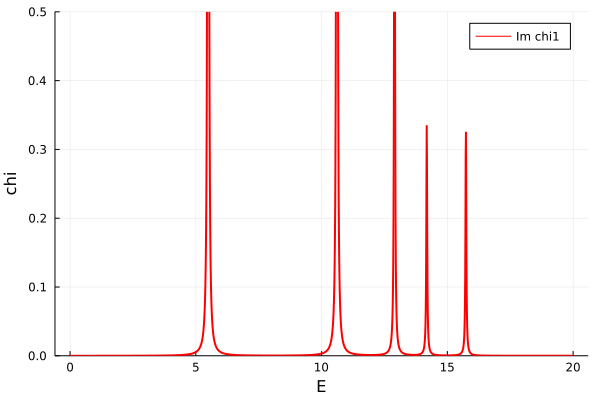

In [11]:
Trange=0.1:0.2:20
anim = @animate for T in Trange
    SuscPlotFreq(H,T,0.02,0:0.01:20,Sz(1),imonly=true, yrange=(0,0.5))
end
gif(anim, "anim_fps5.gif", fps = 5)